In [3]:
import pandas as pd
import numpy as np
import scipy.stats
import phik
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import uncertainties as unc
import uncertainties.unumpy as unp
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import bamt.Networks as Nets
import bamt.Preprocessors as pp
from sklearn import preprocessing
from bamt.Networks import BigBraveBN

from pgmpy.estimators import K2Score

Шаг 1. Выберите переменные для семплирования из вашего набора данных (всего - около 10 переменных,
1-2 - целевые переменные, остальные - предикторы).

In [214]:
data = pd.read_csv('water_potability 2.csv')

In [195]:
data.shape

(3276, 10)

In [196]:
data.head(10)

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0
5,5.584087,188.313324,28748.687739,7.544869,326.678363,280.467916,8.399735,54.917862,2.559708,0
6,10.223862,248.071735,28749.716544,7.513408,393.663396,283.651634,13.789695,84.603556,2.672989,0
7,8.635849,203.361523,13672.091764,4.563009,303.309771,474.607645,12.363817,62.798309,4.401425,0
8,NaN,118.988579,14285.583854,7.804174,268.646941,389.375566,12.706049,53.928846,3.595017,0
9,11.180284,227.231469,25484.508491,9.077200,404.041635,563.885481,17.927806,71.976601,4.370562,0


In [197]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


In [198]:
data.columns

Index(['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity',
       'Organic_carbon', 'Trihalomethanes', 'Turbidity', 'Potability'],
      dtype='object')

In [219]:
data = data[['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity',
       'Organic_carbon', 'Trihalomethanes', 'Turbidity']].dropna()

In [200]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2011 entries, 3 to 3271
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2011 non-null   float64
 1   Hardness         2011 non-null   float64
 2   Solids           2011 non-null   float64
 3   Chloramines      2011 non-null   float64
 4   Sulfate          2011 non-null   float64
 5   Conductivity     2011 non-null   float64
 6   Organic_carbon   2011 non-null   float64
 7   Trihalomethanes  2011 non-null   float64
 8   Turbidity        2011 non-null   float64
dtypes: float64(9)
memory usage: 157.1 KB


Шаг 2. Выберите постановку задачи для регрессии. Оцените многомерную корреляцию (целевая
переменная - предикторы).

Цель - Предсказать жесткость воды (Hardness) 

In [201]:
phik_overview = data.phik_matrix()

interval columns not set, guessing: ['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity', 'Organic_carbon', 'Trihalomethanes', 'Turbidity']


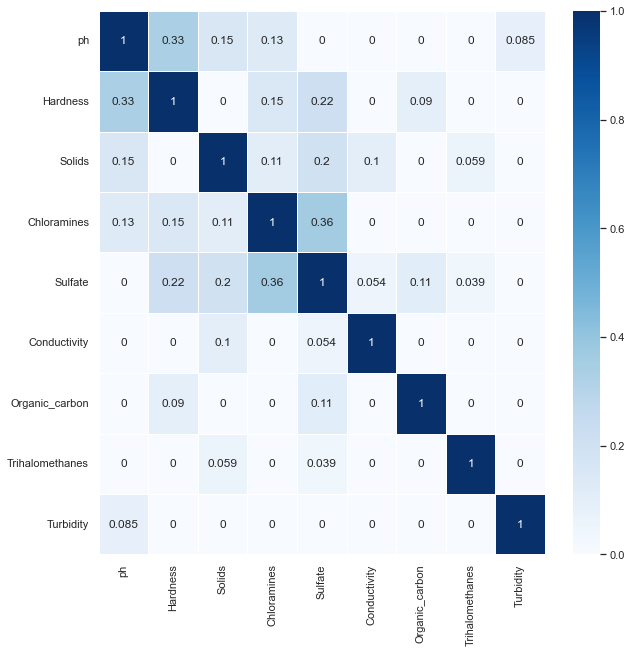

In [202]:
figure, ax = plt.subplots(1, 1, figsize=(10, 10))
heatmap = sns.heatmap(phik_overview, annot=True, linewidth=0.5, cmap="Blues")

In [203]:
phik_overview['Hardness'].sort_values(ascending = False)

Hardness           1.000000
ph                 0.332810
Sulfate            0.216041
Chloramines        0.146433
Organic_carbon     0.090286
Solids             0.000000
Conductivity       0.000000
Trihalomethanes    0.000000
Turbidity          0.000000
Name: Hardness, dtype: float64

Шаг 3. Постройте регрессионную модель и проведите анализ мультиколлинеарности и регуляризации (при
необходимости).

In [220]:
x_train, x_test, y_train, y_test = train_test_split(
    data[['ph', 'Chloramines', 'Sulfate',
       'Organic_carbon']], 
    data['Hardness'])

In [221]:
reg = LinearRegression()
reg.fit(x_train, y_train)
pred = reg.predict(x_test)
mae = mean_absolute_error(y_test, pred)
mse = mean_squared_error(y_test, pred)
r2 = r2_score(y_test, pred)

print('Mean Absolute Error: {:.3f}'.format(mae))
print('Mean Squared Error: {:.3f}'.format(mse))

Mean Absolute Error: 23.729
Mean Squared Error: 994.381


Шаг 4. Проанализируйте качество регрессионной модели (распределение остатков, коэффициент
детерминации). Постройте вероятностный интервал для результатов регрессии.

Анализ регрессионных остатков.

In [222]:
y_logits = np.array(reg.predict(x_train))
y_target = np.array(y_train)

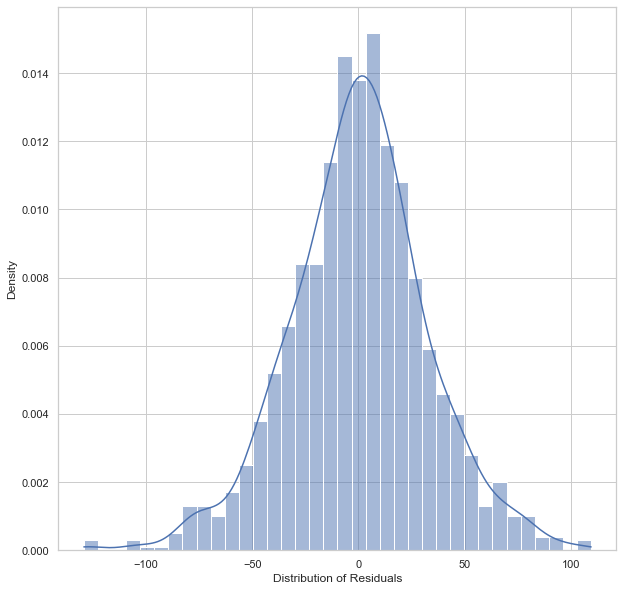

In [223]:
data = y_target - y_logits

figure, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.set_theme(style='whitegrid')

residuals = sns.histplot(data, ax=ax, kde=True, stat='density')
residuals.set(xlabel='Distribution of Residuals')

plt.show()

In [224]:
def return_test(array, distribution, cdf):
    args = distribution.fit(array)
    
    kstest = scipy.stats.kstest(array, cdf=cdf, args=args).pvalue
    cramervonmises = scipy.stats.cramervonmises(array, cdf=cdf, args=args).pvalue
    
    print('Kolmogorov-Smirnov Test: {:.5f}'.format(kstest))
    print('Cramer–Von Mises Test: {:.5f}'.format(cramervonmises))

In [225]:
return_test(data, distribution=scipy.stats.norm, cdf='norm')

Kolmogorov-Smirnov Test: 0.09388
Cramer–Von Mises Test: 0.04492


In [227]:
def return_biplot(array, distribution):
    figure, ax = plt.subplots(1, 1, figsize=(5, 5))
    sns.set_theme(style='whitegrid', palette='pastel')
    
    args = distribution.fit(array)
    scipy.stats.probplot(array, dist=distribution, sparams=(args), plot=ax)
    
    ax.get_lines()[0].set_marker('o')
    
    ax.get_lines()[1].set_ls('--')
    ax.get_lines()[1].set_color('black')
    ax.get_lines()[1].set_linewidth(0.75)
    
    plt.show()

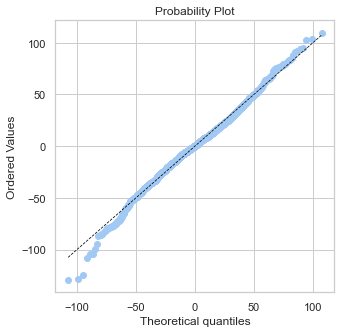

In [228]:
return_biplot(data, distribution=scipy.stats.norm)

Коэффициент детерминации R^2

In [229]:
r2 = r2_score(y_test, pred)
print(r2)

-0.02668878031094124


Вероятностный интервал для результатов регрессии

In [88]:
def conf_n_pred(x, y):
    n = len(y)
    def f(x, a, b):
        return a * x + b
    popt, pcov = curve_fit(f, x, y)
    a = popt[0]
    b = popt[1]
    a,b = unc.correlated_values(popt, pcov)
    px = np.linspace(min(x), max(x), 100)
    py = a*px+b
    nom = unp.nominal_values(py)
    std = unp.std_devs(py)
    def predband(x, xd, yd, p, func, conf=0.95):
        alpha = 1.0 - conf    
        N = xd.size         
        var_n = len(p) 
        q = stats.t.ppf(1.0 - alpha / 2.0, N - var_n)
        se = np.sqrt(1. / (N - var_n) * \
                     np.sum((yd - func(xd, *p)) ** 2))
        sx = (x - xd.mean()) ** 2
        sxd = np.sum((xd - xd.mean()) ** 2)
        yp = func(x, *p)
        dy = q * se * np.sqrt(1.0+ (1.0/N) + (sx/sxd))
        lpb, upb = yp - dy, yp + dy
        return lpb, upb
    
    figure, ax = plt.subplots(1, 1, figsize=(20, 10))
    plt.scatter(x, y, s=3, label='Data')
    lpb, upb = predband(px, x, y, popt, f, conf=0.95)

    plt.plot(px, nom, c='black', label='y=a x + b')

    plt.plot(px, nom - 1.96 * std, c='orange',\
             label='95% Confidence Region')
    plt.plot(px, nom + 1.96 * std, c='orange')
   
    plt.plot(px, lpb, 'k--',label='95% Prediction Band')
    plt.plot(px, upb, 'k--')
    plt.ylabel('y')
    plt.xlabel('x')
    plt.legend(loc='best')

    plt.savefig('regression.png')
    plt.show()


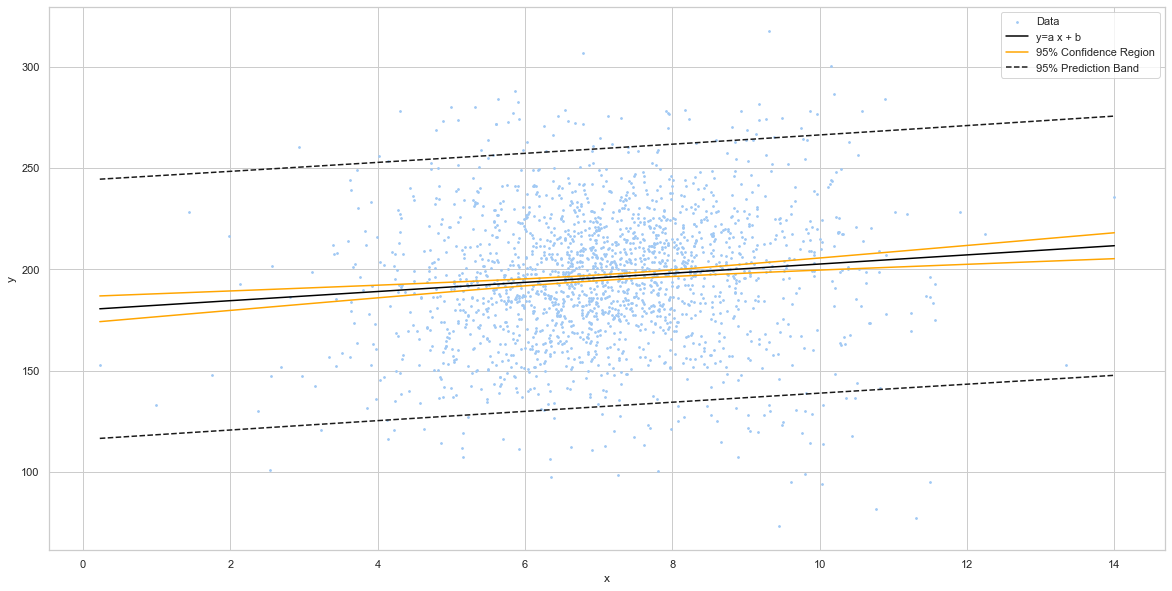

In [90]:
conf_n_pred(data['ph'], data['Hardness'])

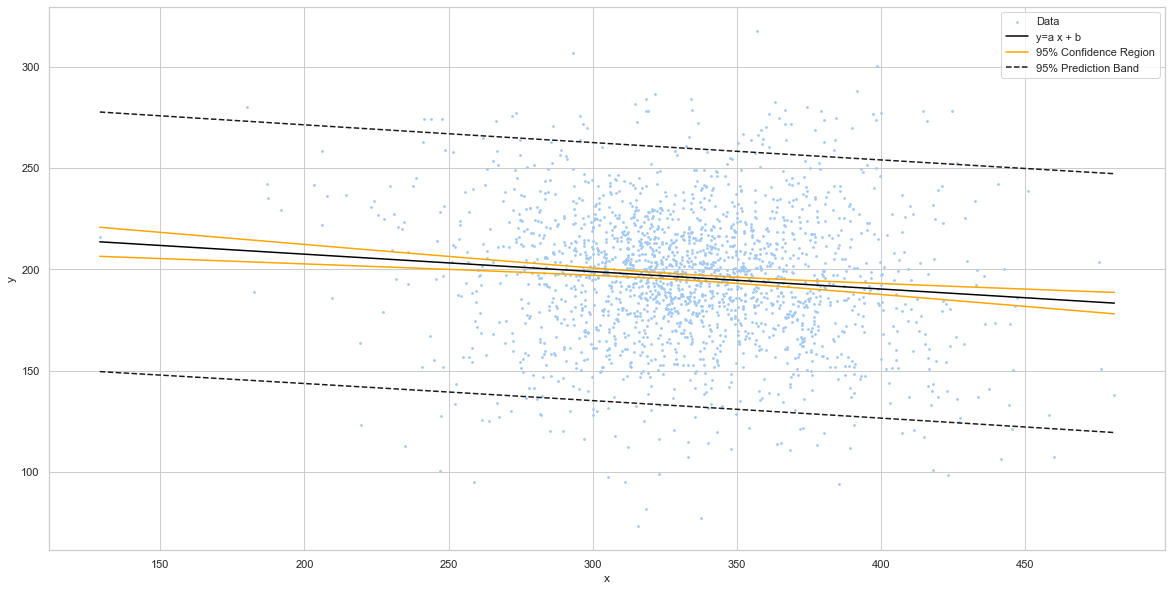

In [91]:
conf_n_pred(data['Sulfate'], data['Hardness'])

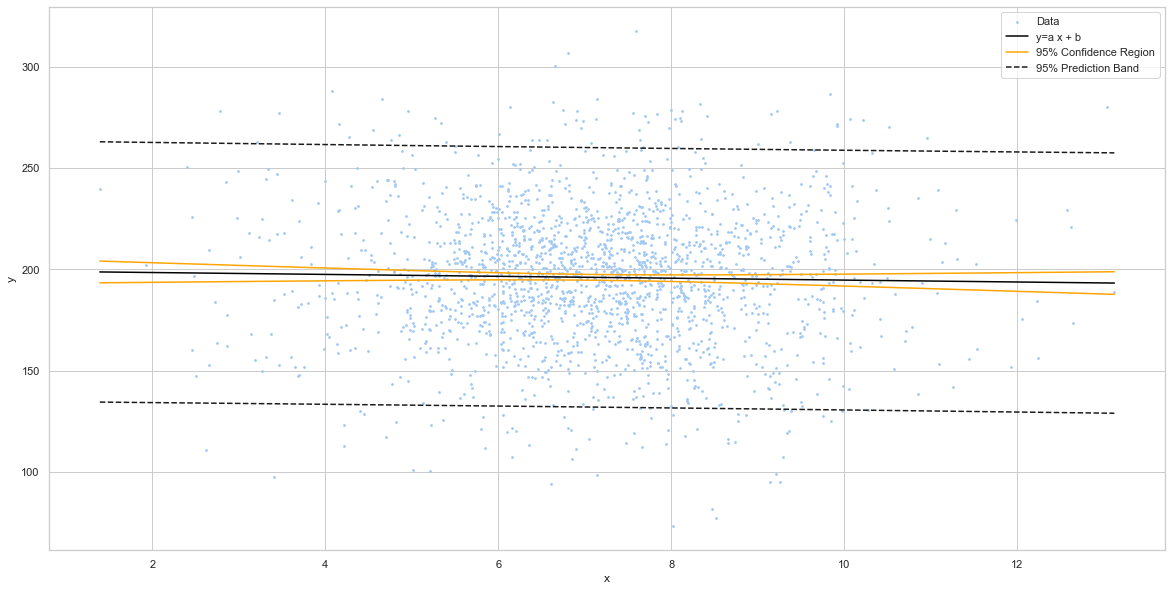

In [92]:
conf_n_pred(data['Chloramines'], data['Hardness'])

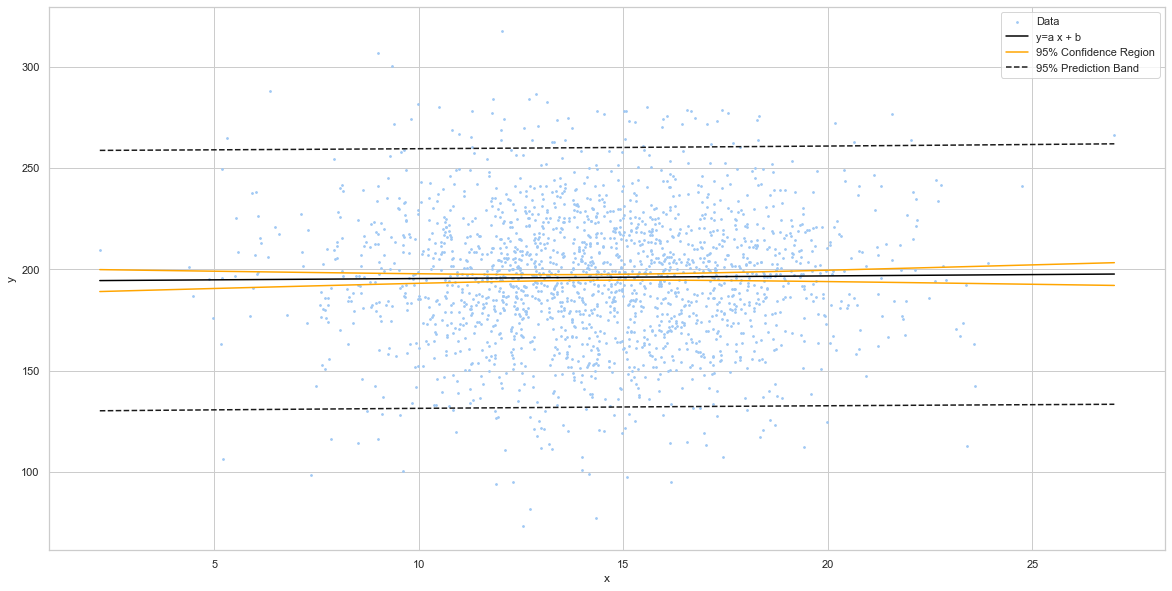

In [93]:
conf_n_pred(data['Organic_carbon'], data['Hardness'])

Шаг 5. Постройте байесовскую сеть для выбранного набора переменных. Определите ее структуру на
основе многомерного анализа или обучите структуру с помощью 2 выбранных алгоритмов.

In [130]:
df_bn = data[['ph', 'Chloramines', 'Sulfate',
       'Organic_carbon', 'Hardness']]

In [131]:
encoder = preprocessing.LabelEncoder()
discretizer = preprocessing.KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')

p = pp.Preprocessor([('encoder', encoder), ('discretizer', discretizer)])
discretized_data, est = p.apply(df_bn)

2022-11-04 16:03:53,091 | INFO     | Preprocessors.py-scan-0091 | No one column is discrete


In [132]:
bn = Nets.ContinuousBN() 
info = p.info

In [125]:
bn.add_nodes(info)
bn.add_edges(discretized_data, scoring_function=('MI',))

In [126]:
bn.get_info()

,name,node_type,data_type,parents,parents_types
0,ph,Gaussian,cont,[],[]
1,Chloramines,Gaussian,cont,[ph],[cont]
2,Sulfate,Gaussian,cont,[ph],[cont]
3,Organic_carbon,Gaussian,cont,[ph],[cont]
4,Hardness,Gaussian,cont,[Organic_carbon],[cont]


In [127]:
bn.plot('Simple.html')

In [133]:
bn.add_nodes(info)
bn.add_edges(discretized_data, scoring_function=('LL',))

In [134]:
bn.get_info()

,name,node_type,data_type,parents,parents_types
0,ph,Gaussian,cont,[],[]
1,Chloramines,Gaussian,cont,[ph],[cont]
2,Sulfate,Gaussian,cont,[ph],[cont]
3,Organic_carbon,Gaussian,cont,[ph],[cont]
4,Hardness,Gaussian,cont,[Organic_carbon],[cont]


In [135]:
bn.plot('Simple.html')

Шаг 6. Выполните задачу регрессии с помощью БС. Постройте вероятностный интервал для результатов
регрессии на основе семплирования из БС. Оцените качество предсказания БС.

In [136]:
bn.fit_parameters(df_bn)

In [137]:
test = data[['ph', 'Chloramines', 'Sulfate',
       'Organic_carbon', 'Hardness']].sample(100)
target = test['Hardness'].values
test = test.drop(columns=['Hardness'])
test.reset_index(inplace=True, drop=True)
test

,ph,Chloramines,Sulfate,Organic_carbon
0,5.290667,9.272066,358.547147,11.220817
1,10.026224,6.614114,385.402659,11.887161
2,6.632990,7.347361,331.301877,19.640923
3,7.710138,8.212234,269.859799,9.320040
4,5.495976,7.471728,416.888527,12.300193
...,...,...,...,...
95,5.115817,6.060713,323.836384,10.966486
96,4.933106,7.757702,317.935411,14.261743
97,4.229225,6.844548,304.275125,13.489424
98,8.245187,9.369642,406.047609,14.801329


In [138]:
pred = bn.predict(test, 5)

100%|█████████████████████████████████████████| 100/100 [00:03<00:00, 26.55it/s]


In [139]:
mean_squared_error(data.Hardness.sample(100), pred['Hardness'], squared=False)

31.765492146926906

In [140]:
pred

{'Hardness': [195.56091977797848,
  195.64740763114878,
  196.65380433514667,
  195.31420905465467,
  195.70101695639121,
  196.41092206910935,
  196.62029351496167,
  195.80171350719635,
  195.8903409729232,
  196.39989123788953,
  196.15431591630565,
  196.4765554165128,
  195.83200543468666,
  195.73143652400384,
  196.33263803978917,
  195.64300328844917,
  195.86419324000488,
  195.65111695256718,
  195.91017484022413,
  196.08772577282159,
  196.66702947125867,
  196.3086463117129,
  196.25432808302165,
  195.96310065570987,
  196.4094002741658,
  196.03835163973181,
  195.8565721283001,
  195.970363587306,
  196.13660204292188,
  195.92939254107253,
  195.5701313357988,
  195.91285482765048,
  195.54982160074357,
  195.85577663396327,
  195.38970925224416,
  195.7422992685741,
  196.03330028200344,
  195.82859302135623,
  196.01088171628643,
  195.98423145465108,
  196.4242011356466,
  195.84607804536557,
  196.49974175868192,
  195.70018324299363,
  196.65187032856537,
  195.64

In [141]:
sample = bn.sample(2000)

100%|████████████████████████████████████| 2000/2000 [00:00<00:00, 20203.10it/s]


In [142]:
sample

,ph,Chloramines,Sulfate,Organic_carbon,Hardness
0,4.839661,5.599810,282.172504,15.906877,258.007269
1,5.393727,7.942799,405.366841,7.295291,181.737135
2,7.141946,6.457113,325.459372,16.044165,232.134960
3,7.438663,7.781724,368.787098,17.231045,128.235886
4,4.424154,9.278189,373.157180,10.639412,259.203349
...,...,...,...,...,...
1995,2.371766,8.575755,324.157443,14.278636,253.501176
1996,7.782397,5.912013,283.976519,10.062479,202.167606
1997,5.056051,6.698521,271.939884,17.689036,222.101379
1998,8.358128,9.371542,286.715836,13.934618,136.474403


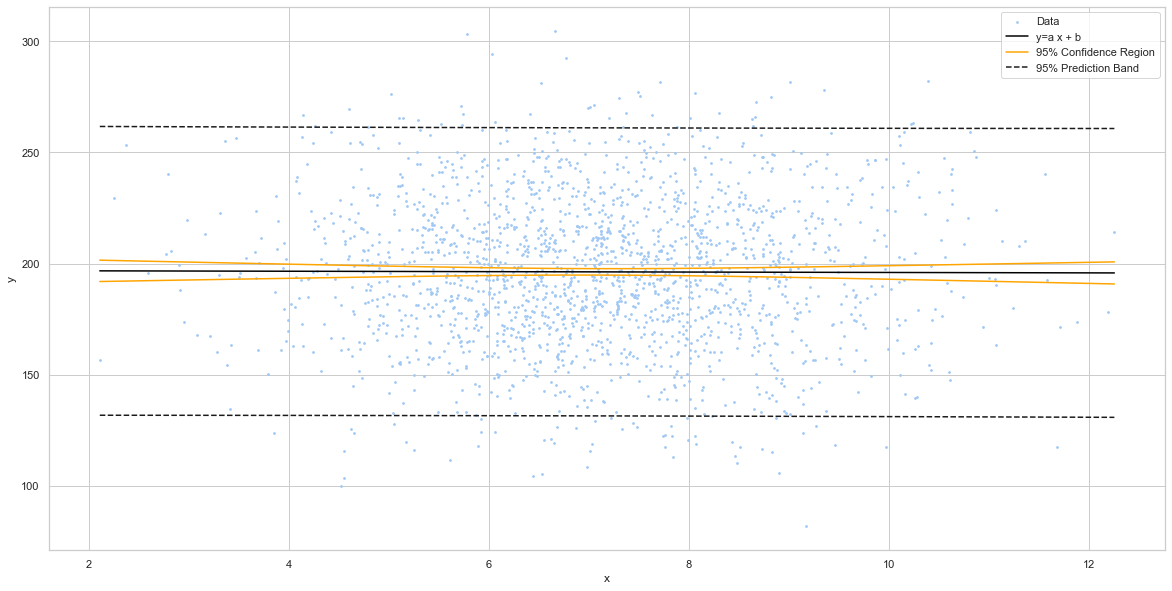

In [143]:
conf_n_pred(sample['ph'], sample['Hardness'])

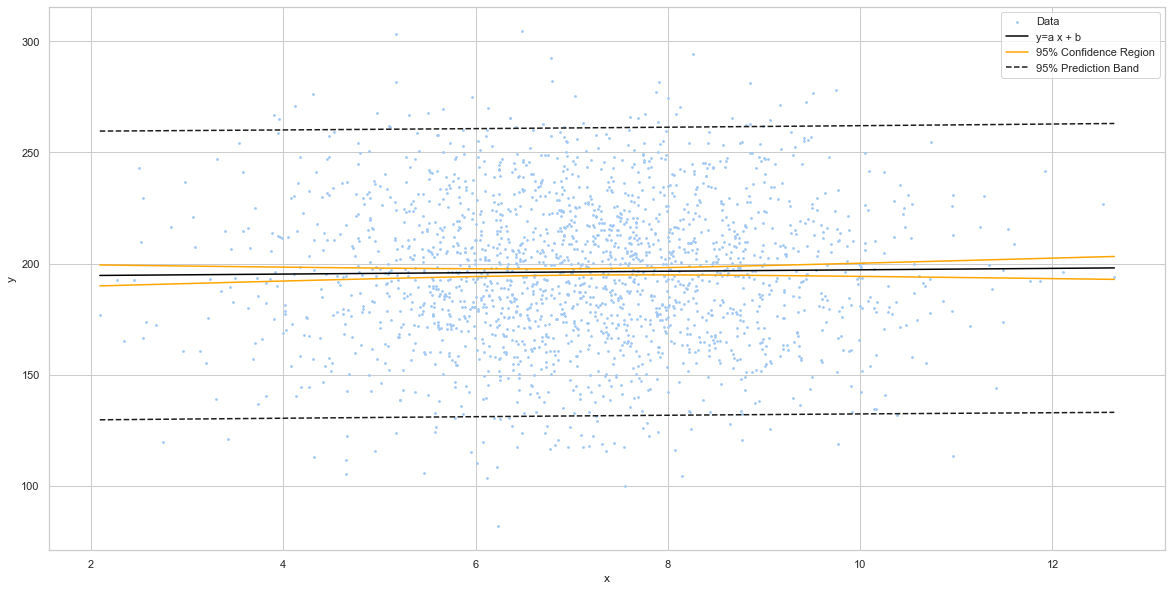

In [145]:
conf_n_pred(sample['Chloramines'], sample['Hardness'])

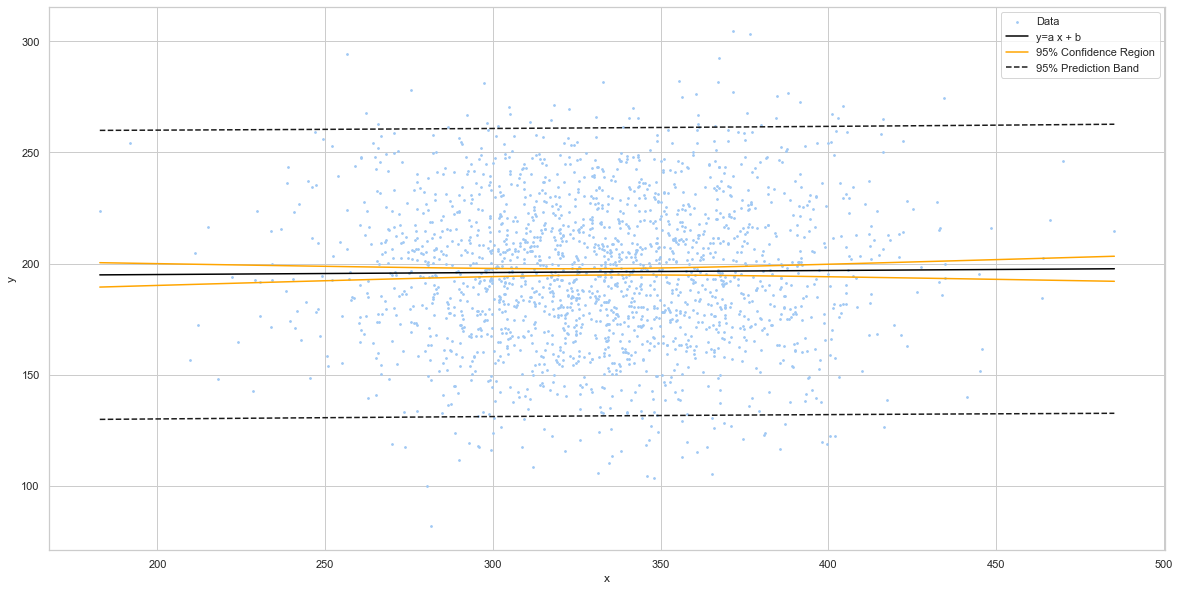

In [146]:
conf_n_pred(sample['Sulfate'], sample['Hardness'])

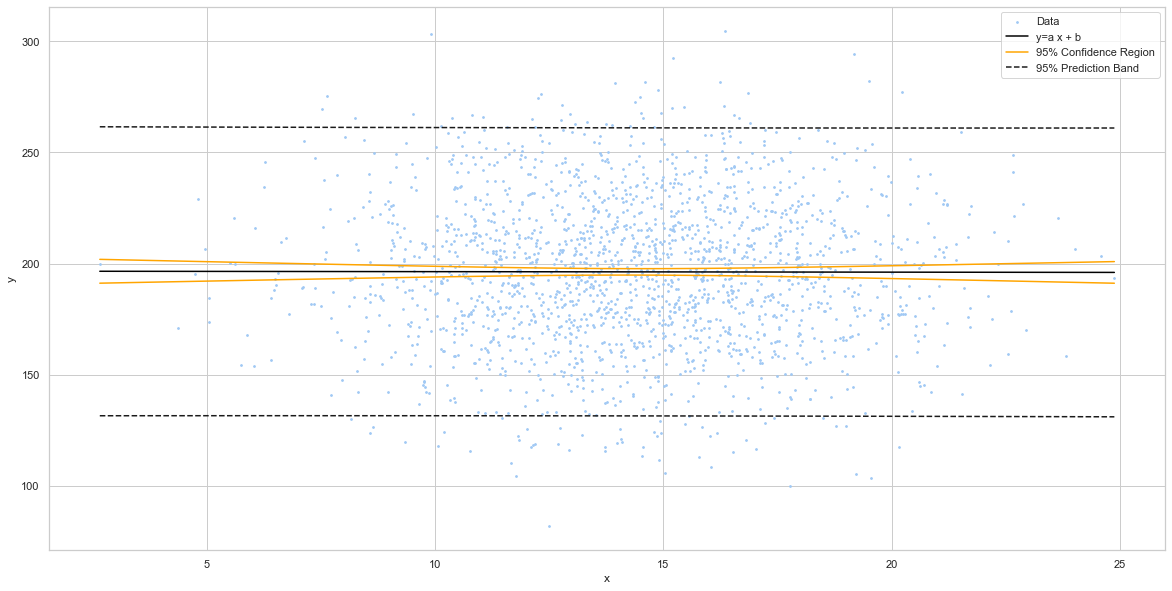

In [147]:
conf_n_pred(sample['Organic_carbon'], sample['Hardness'])